本报告为划分中国的货币信用周期的第一版。
（2024.12.20）我们尝试了以DR007（收盘价涨跌）划分货币周期，以（M2+社会融资规模）（同比增速）划分信用周期；
我们的结果是，这样的划分方法并不能有效区分大类资产的轮动表现。

导入包

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.filters.hp_filter import hpfilter

plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体
plt.rcParams['axes.unicode_minus'] = False   # 防止负号显示问题

首先是货币周期划分，加载DR007数据（日度）

In [56]:
df_DR007 = pd.read_csv(r"../data/DR007.IB.csv")[:-1]

我们可视化df_DR007['收盘价']

<Axes: title={'center': 'pct'}, xlabel='日期'>

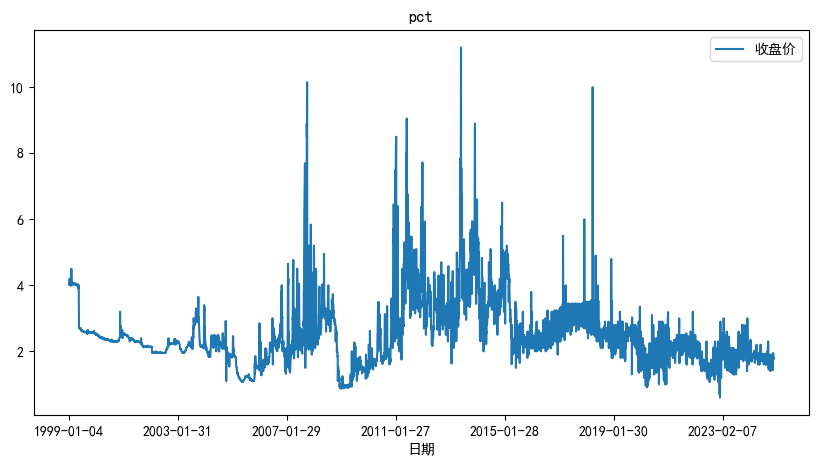

In [57]:
df_DR007.plot(x='日期', y='收盘价', kind='line', figsize=(10, 5), title='pct')

我们用HP滤波来提取趋势成分

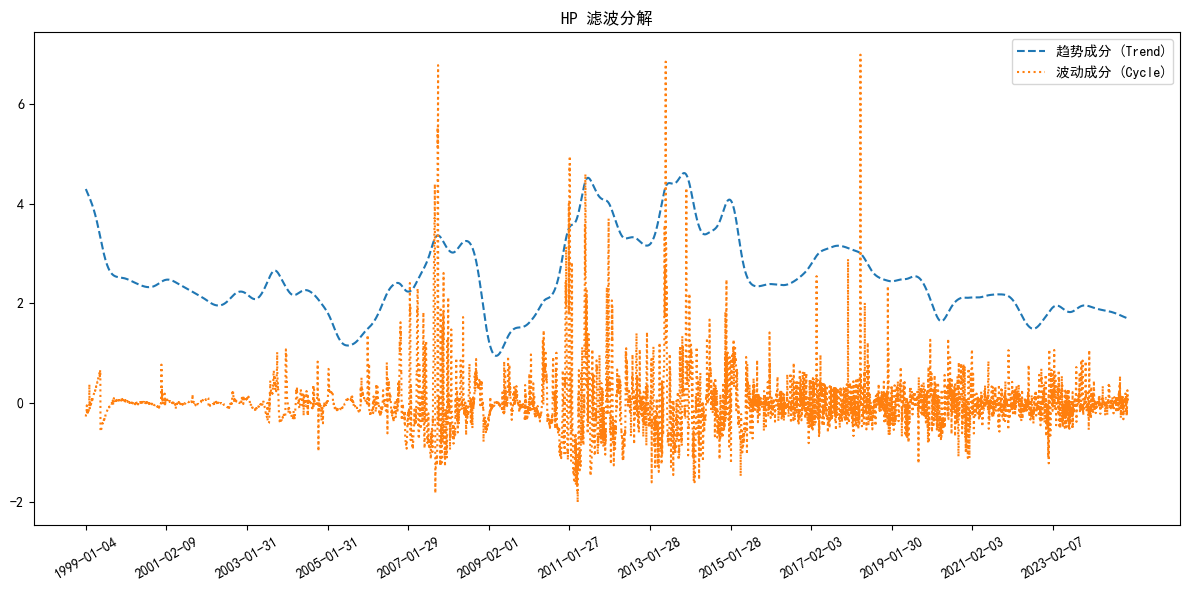

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.filters.hp_filter import hpfilter

cycle, trend = hpfilter(df_DR007['收盘价'], lamb=10**6)

plt.figure(figsize=(12, 6))
plt.plot(df_DR007['日期'], trend, '--', label="趋势成分 (Trend)")
plt.plot(df_DR007['日期'], cycle, ':', label="波动成分 (Cycle)")

ticks_to_use = df_DR007['日期'][::500]
plt.xticks(ticks_to_use, rotation=30)  

plt.legend()
plt.title("HP 滤波分解")
plt.tight_layout()  
plt.show()

我们提取其波峰和波谷，并设定阈值为20%：只有当高（低）点相对于波谷（峰）变化幅度超过该阈值，才成为波峰（谷）

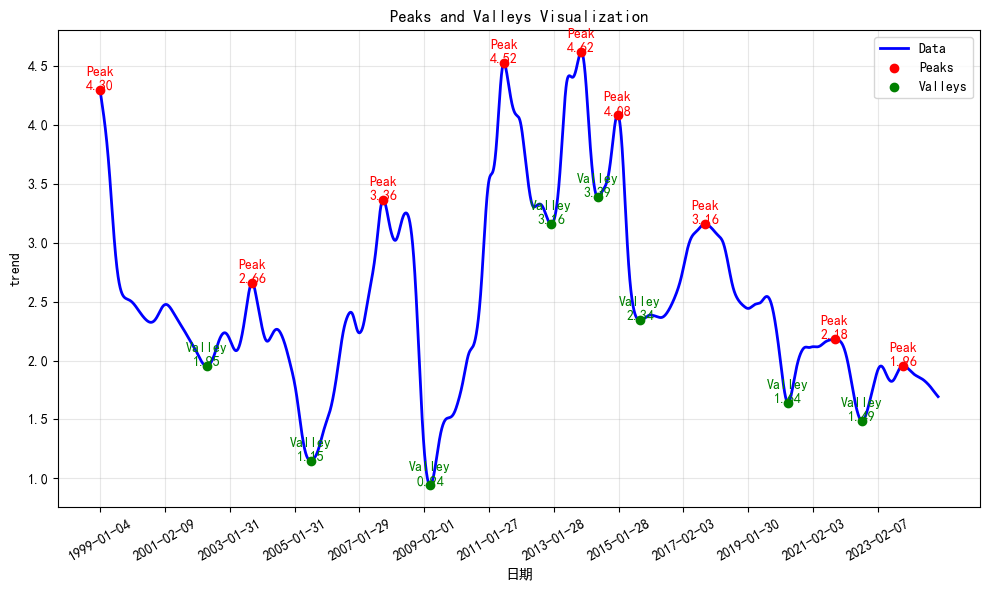

In [59]:
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

def mark_peaks_and_valleys(df, column, peak_threshold=0.1, valley_threshold=0.1):
    data = df[column].values
    peaks, _ = find_peaks(data)
    valleys, _ = find_peaks(-data)
    labels = ['' for _ in range(len(data))]
    peak_points = [{'index': idx, 'type': 'Peak', 'value': data[idx]} for idx in peaks]
    valley_points = [{'index': idx, 'type': 'Valley', 'value': data[idx]} for idx in valleys]
    all_points = peak_points + valley_points
    all_points.sort(key=lambda x: x['index'])
    significant_points = []
    last_point = None
    for point in all_points:
        if last_point is None:
            significant_points.append(point)
            last_point = point
        else:
            if point['type'] != last_point['type']:
                if point['type'] == 'Peak':
                    if point['value'] >= last_point['value'] * (1 + peak_threshold):
                        significant_points.append(point)
                        last_point = point
                else:
                    if point['value'] <= last_point['value'] * (1 - valley_threshold):
                        significant_points.append(point)
                        last_point = point
            else:
                if point['type'] == 'Peak':
                    if point['value'] > last_point['value']:
                        significant_points[-1] = point
                        last_point = point
                else:
                    if point['value'] < last_point['value']:
                        significant_points[-1] = point
                        last_point = point
    if len(significant_points) > 0:
        first_point = significant_points[0]
        if first_point['index'] > 0:
            first_point = {'index': 0, 'type': 'Peak' if data[0] > data[1] else 'Valley', 'value': data[0]}
            significant_points.insert(0, first_point)
    for point in significant_points:
        labels[point['index']] = point['type']
    df['Label'] = labels
    return df

def plot_peaks_and_valleys(df, column):
    data = df[column]
    peaks = df[df['Label'] == 'Peak'].index
    valleys = df[df['Label'] == 'Valley'].index
    plt.figure(figsize=(10, 6))
    plt.plot(df['日期'], data, label='Data', color='blue', linewidth=2)
    plt.scatter(df.loc[peaks, '日期'], data[peaks], color='red', label='Peaks', zorder=5)
    for peak in peaks:
        plt.text(df.loc[peak, '日期'], data[peak], f"Peak\n{data[peak]:.2f}", color='red', ha='center', fontsize=10)
    plt.scatter(df.loc[valleys, '日期'], data[valleys], color='green', label='Valleys', zorder=5)
    for valley in valleys:
        plt.text(df.loc[valley, '日期'], data[valley], f"Valley\n{data[valley]:.2f}", color='green', ha='center', fontsize=10)
    ticks_to_use = df['日期'][::500]
    plt.xticks(ticks_to_use, rotation=30)
    plt.legend()
    plt.title('Peaks and Valleys Visualization')
    plt.xlabel('日期')
    plt.ylabel(column)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

df_DR007['trend'] = trend
result_df = mark_peaks_and_valleys(df_DR007, 'trend', peak_threshold=0.2, valley_threshold=0.2)
plot_peaks_and_valleys(result_df, 'trend')

我们观察到共有16个区间，下面查看每个区间的时间范围，以及其长度

In [60]:
peaks_dates = df_DR007[df_DR007['Label'] == 'Peak']['日期'].reset_index(drop=True)
valleys_dates = df_DR007[df_DR007['Label'] == 'Valley']['日期'].reset_index(drop=True)

periods = []
i, j = 0, 0
while i < len(peaks_dates) or j < len(valleys_dates):
    if j < len(valleys_dates) and (i >= len(peaks_dates) or valleys_dates[j] < peaks_dates[i]):
        if i > 0:  
            periods.append({
                'start_date': peaks_dates[i-1],
                'end_date': valleys_dates[j],
                '货币周期': '宽货币'
            })
        j += 1
    elif i < len(peaks_dates):
        if j > 0:  
            periods.append({
                'start_date': valleys_dates[j-1],
                'end_date': peaks_dates[i],
                '货币周期': '紧货币'
            })
        i += 1

periods_df = pd.DataFrame(periods)

periods_df['start_date'] = pd.to_datetime(periods_df['start_date'])
periods_df['end_date'] = pd.to_datetime(periods_df['end_date'])

periods_df['持续时间（月）'] = (periods_df['end_date'].dt.year - periods_df['start_date'].dt.year) * 12 + \
                                (periods_df['end_date'].dt.month - periods_df['start_date'].dt.month)

periods_df

,start_date,end_date,货币周期,持续时间（月）
0,1999-01-04,2002-05-22,宽货币,40
1,2002-05-22,2003-10-15,紧货币,17
2,2003-10-15,2005-07-29,宽货币,21
3,2005-07-29,2007-10-25,紧货币,27
4,2007-10-25,2009-04-03,宽货币,18
5,2009-04-03,2011-07-15,紧货币,27
6,2011-07-15,2012-12-28,宽货币,17
7,2012-12-28,2013-12-04,紧货币,12
8,2013-12-04,2014-06-11,宽货币,6
9,2014-06-11,2015-01-16,紧货币,7


下面是信用周期划分，加载M2和社融数据

In [28]:
social_financing_data = pd.read_csv(r"../data/清理后的社融同比数据.csv", encoding='gbk')
m2_data = pd.read_csv(r"../data/清理后的M2同比数据.csv", encoding='gbk')

social_financing_data = social_financing_data.drop(social_financing_data.index[-1])[::-1]
m2_data = m2_data.drop(m2_data.index[-1])[::-1]

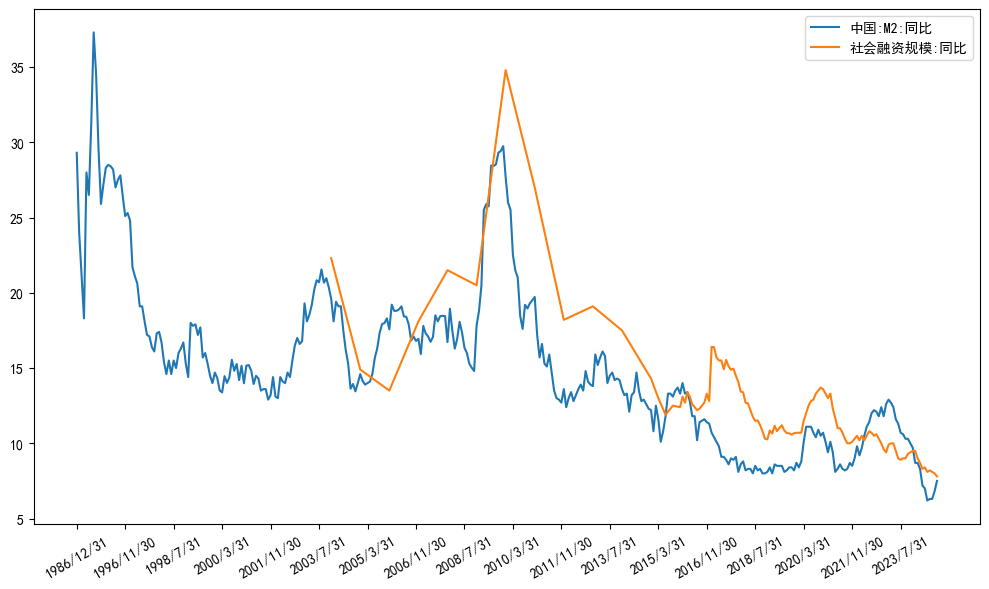

In [35]:
plt.figure(figsize=(10, 6))
plt.plot(m2_data['日期'], m2_data['中国:M2:同比'], label='中国:M2:同比')
plt.plot(social_financing_data['日期'], social_financing_data['中国:社会融资规模存量:同比'], label='社会融资规模:同比')

ticks_to_use = m2_data['日期'][::20]
plt.xticks(ticks_to_use, rotation=30)  
plt.legend()
plt.tight_layout()  
plt.show()

In [36]:
social_financing_data['日期'] = pd.to_datetime(social_financing_data['日期'])

social_financing_data['年份'] = social_financing_data['日期'].dt.year
yearly_counts = social_financing_data.groupby('年份').size()
years_with_less_data = yearly_counts[yearly_counts <= 4].index

if len(years_with_less_data) > 0:
    min_year = years_with_less_data.min()
    max_year = years_with_less_data.max()
    print(f"每年数据少于等于 4 条的年份区间：{min_year} - {max_year}")
else:
    print("没有年份符合数据少于等于 4 条的区间")

每年数据少于等于 4 条的年份区间：2003 - 2015


In [97]:
# 筛选出m2的 2003 到 2015 年的数据
m2_data['日期'] = pd.to_datetime(m2_data['日期'])
m2_data_min_max = m2_data[(m2_data['日期'].dt.year >= min_year) & (m2_data['日期'].dt.year <= max_year)]

m2_data_min_max

,日期,中国:M2:同比
261,2003-01-31,19.30
260,2003-02-28,18.10
259,2003-03-31,18.54
258,2003-04-30,19.20
257,2003-05-31,20.20
...,...,...
110,2015-08-31,13.30
109,2015-09-30,13.10
108,2015-10-31,13.50
107,2015-11-30,13.70


In [98]:
import datetime
#融合后半段预测所需的M2和社融数据集
m2_data_2 = m2_data[(m2_data['日期'].dt.year >= max_year + 1) & (m2_data['日期'].dt.year <= datetime.datetime.now().year)]
social_financing_data_2 = social_financing_data[(social_financing_data['日期'].dt.year >= max_year + 1) & (social_financing_data['日期'].dt.year <= datetime.datetime.now().year)]
merged_data = pd.merge(m2_data_2, social_financing_data_2, on='日期', how='inner')
merged_data

,日期,中国:M2:同比,中国:社会融资规模存量:同比,年份
0,2016-01-31,14.0,13.1,2016
1,2016-02-29,13.3,12.7,2016
2,2016-03-31,13.4,13.4,2016
3,2016-04-30,12.8,13.1,2016
4,2016-05-31,11.8,12.6,2016
...,...,...,...,...
101,2024-06-30,6.2,8.1,2024
102,2024-07-31,6.3,8.2,2024
103,2024-08-31,6.3,8.1,2024
104,2024-09-30,6.8,8.0,2024


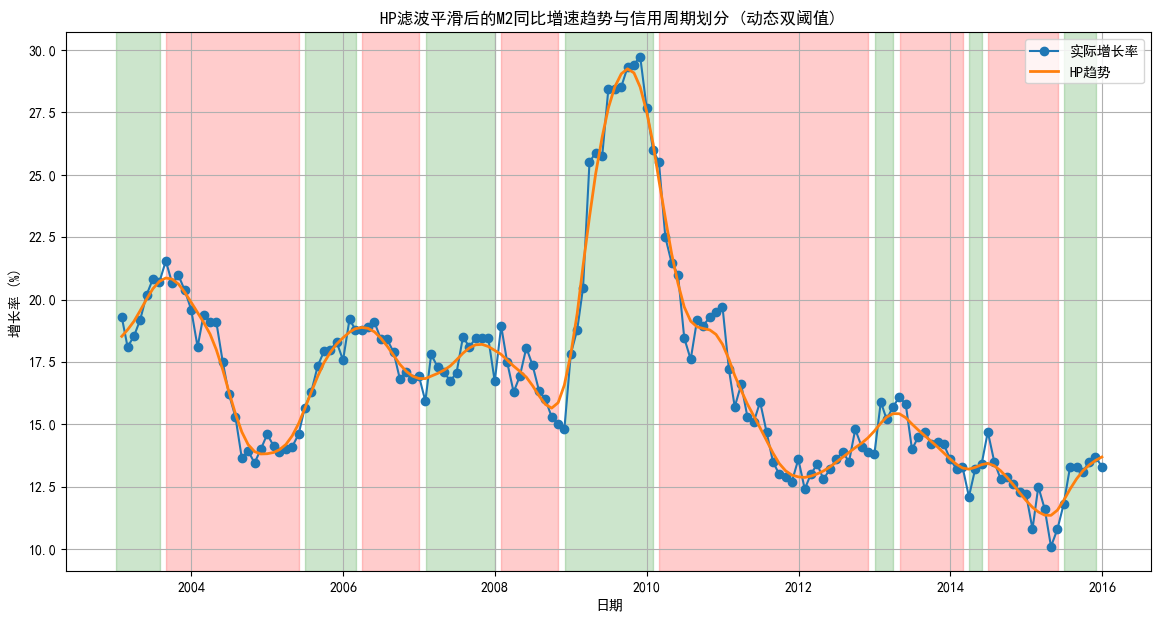

,信用周期,开始日期,结束日期,时长(月)
0,宽信用,2003-01,2003-08,8
1,紧信用,2003-09,2005-06,22
2,宽信用,2005-07,2006-03,9
3,紧信用,2006-04,2007-01,10
4,宽信用,2007-02,2008-01,12
5,紧信用,2008-02,2008-11,10
6,宽信用,2008-12,2010-02,15
7,紧信用,2010-03,2012-12,34
8,宽信用,2013-01,2013-04,4
9,紧信用,2013-05,2014-03,11


In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.filters.hp_filter import hpfilter

def segment_credit_cycles_with_dynamic_threshold(df, 
                                                 growth_col='中国:M2:同比', 
                                                 hp_lambda=10, 
                                                 threshold=0.05, 
                                                 consecutive=3,
                                                 ratio_tight=0.5,
                                                 ratio_wide=1.5,
                                                 window_years=5):
    """
    使用 HP 滤波器平滑后划分信用周期，并基于最近 window_years 年窗口计算动态阈值。
    
    动态阈值设计：
    - 在每个时点，根据过去 window_years 年(例如5年)的数据计算参考均值 ref_mean。
    - 当 M2 同比增速 < ref_mean * ratio_tight 时，直接判定为 "紧信用"。
    - 当 M2 同比增速 > ref_mean * ratio_wide 时，直接判定为 "宽信用"。
    - 介于两者之间时，则根据趋势差分进行判断。

    参数:
    - df: 包含时间序列数据的DataFrame，需包含'日期'和增长率列
    - growth_col: 增长率的列名
    - hp_lambda: HP 滤波器的平滑参数
    - threshold: 判断趋势变化的最小差异，默认0.05
    - consecutive: 连续满足条件的月份数，默认3
    - ratio_tight: 当增速低于 (参考均值 * ratio_tight) 时判定为紧信用
    - ratio_wide: 当增速高于 (参考均值 * ratio_wide) 时判定为宽信用
    - window_years: 用于计算参考均值的回溯年数，默认2年

    返回:
    - summary_df: 包含区间信息的汇总 DataFrame
    - trend: HP滤波后的趋势序列
    """
    df = df.copy()
    df = df.sort_values('日期').reset_index(drop=True)
    
    # 确保日期列为 datetime 类型
    if not np.issubdtype(df['日期'].dtype, np.datetime64):
        df['日期'] = pd.to_datetime(df['日期'])
    
    # 应用 HP 滤波器获取趋势
    cycle, trend = hpfilter(df[growth_col], lamb=hp_lambda)
    df['趋势'] = trend
    # 计算趋势变化（差分）
    df['趋势差分'] = df['趋势'].diff()

    def get_dynamic_ref_mean(current_date):
        start_date = current_date - pd.DateOffset(years=window_years)
        ref_mask = (df['日期'] >= start_date) & (df['日期'] < current_date)
        ref_data = df.loc[ref_mask, growth_col]
        # 如果参考期内无数据，则使用全局均值
        return ref_data.mean() if len(ref_data) > 0 else df[growth_col].mean()

    def get_signal(i, threshold, ref_mean):
        trend_diff = df.loc[i, '趋势差分']
        growth_val = df.loc[i, growth_col]

        absolute_threshold_tight = ref_mean * ratio_tight
        absolute_threshold_wide = ref_mean * ratio_wide

        # 优先判断绝对值条件
        if growth_val < absolute_threshold_tight:
            return '紧信用'
        if growth_val > absolute_threshold_wide:
            return '宽信用'

        # 若未满足绝对值条件，则根据趋势差分判断
        if pd.isnull(trend_diff):
            return None
        if trend_diff > threshold:
            return '宽信用'
        elif trend_diff < -threshold:
            return '紧信用'
        else:
            return None

    intervals = []
    consecutive_counter = 0
    first_date = df.loc[0, '日期']
    ref_mean_initial = get_dynamic_ref_mean(first_date)
    first_signal = get_signal(1, threshold, ref_mean_initial)
    current_state = '宽信用' if first_signal is None else first_signal
    current_cycle_start_idx = 0
    
    for i in range(2, len(df)):
        current_date = df.loc[i, '日期']
        ref_mean_current = get_dynamic_ref_mean(current_date)
        signal = get_signal(i, threshold, ref_mean_current)

        if signal is None or signal == current_state:
            consecutive_counter = 0
        else:
            consecutive_counter += 1
            if consecutive_counter >= consecutive:
                cycle_end_idx = i - consecutive + 1
                intervals.append({
                    '信用周期': current_state,
                    '开始日期': df.loc[current_cycle_start_idx, '日期'].strftime('%Y-%m'),
                    '结束日期': df.loc[cycle_end_idx - 1, '日期'].strftime('%Y-%m'),
                    '时长(月)': cycle_end_idx - current_cycle_start_idx
                })
                current_state = signal
                current_cycle_start_idx = cycle_end_idx
                consecutive_counter = 0

    intervals.append({
        '信用周期': current_state,
        '开始日期': df.loc[current_cycle_start_idx, '日期'].strftime('%Y-%m'),
        '结束日期': df.loc[len(df) - 1, '日期'].strftime('%Y-%m'),
        '时长(月)': len(df) - current_cycle_start_idx
    })
    summary_df = pd.DataFrame(intervals)
    
    # 可视化结果
    plt.figure(figsize=(14, 7))
    plt.plot(df['日期'], df[growth_col], label='实际增长率', marker='o', linestyle='-', color='tab:blue')
    plt.plot(df['日期'], trend, label='HP趋势', linewidth=2, color='tab:orange')

    for _, row in summary_df.iterrows():
        start_date = pd.to_datetime(row['开始日期'])
        end_date = pd.to_datetime(row['结束日期'])
        color = 'green' if row['信用周期'] == '宽信用' else 'red'
        plt.axvspan(start_date, end_date, color=color, alpha=0.2)

    plt.xlabel('日期')
    plt.ylabel('增长率 (%)')
    plt.title('HP滤波平滑后的M2同比增速趋势与信用周期划分 (动态双阈值)')
    plt.legend()
    plt.grid(True)
    plt.show()

    return summary_df, trend


df = pd.DataFrame(m2_data_min_max)
summary_df, trend = segment_credit_cycles_with_dynamic_threshold(
     df, 
     growth_col='中国:M2:同比',
     hp_lambda=10,
     threshold=0.03,
     consecutive=3,
     ratio_tight=0.9,
     ratio_wide=1.1,
     window_years=3
 )
summary_df

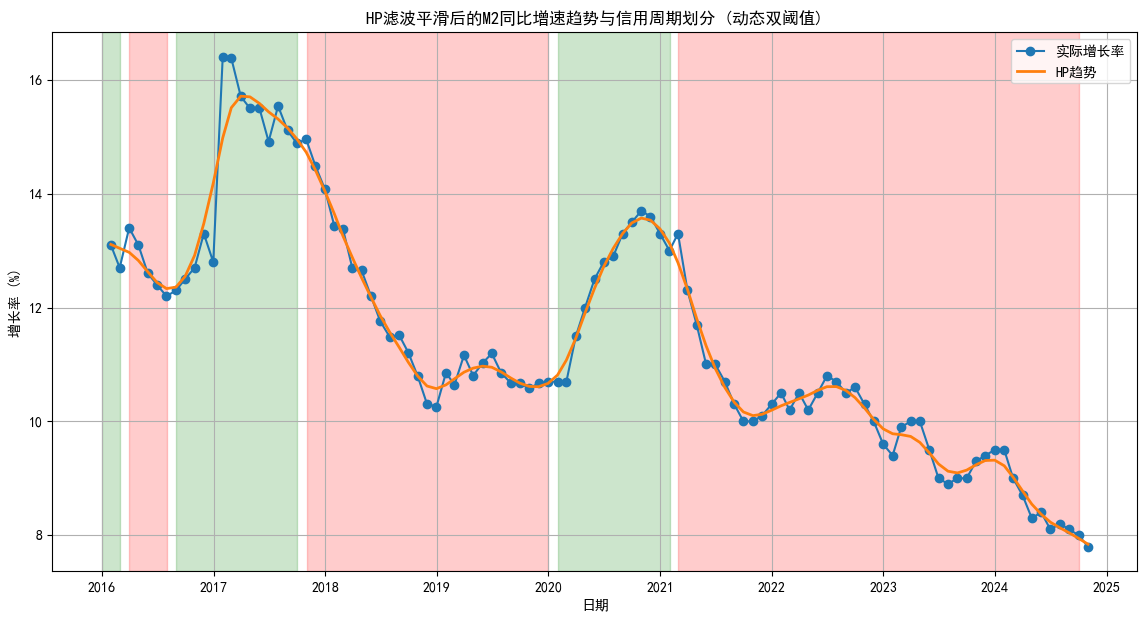

,信用周期,开始日期,结束日期,时长(月)
0,宽信用,2016-01,2016-03,3
1,紧信用,2016-04,2016-08,5
2,宽信用,2016-09,2017-10,14
3,紧信用,2017-11,2020-01,27
4,宽信用,2020-02,2021-02,13
5,紧信用,2021-03,2024-10,44


In [100]:
df = pd.DataFrame(social_financing_data_2)
summary_df, trend = segment_credit_cycles_with_dynamic_threshold(
     df, 
     growth_col='中国:社会融资规模存量:同比',
     hp_lambda=5,
     threshold=0.1,
     consecutive=3,
     ratio_tight=0.95,
     ratio_wide=1.05,
     window_years=2
 )
summary_df

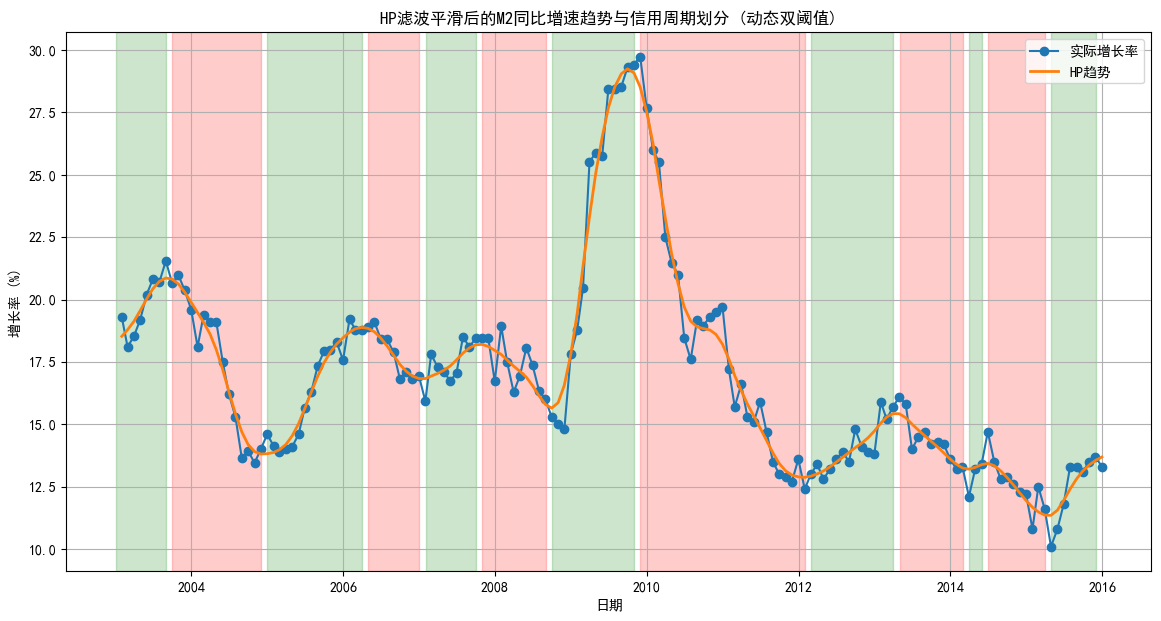

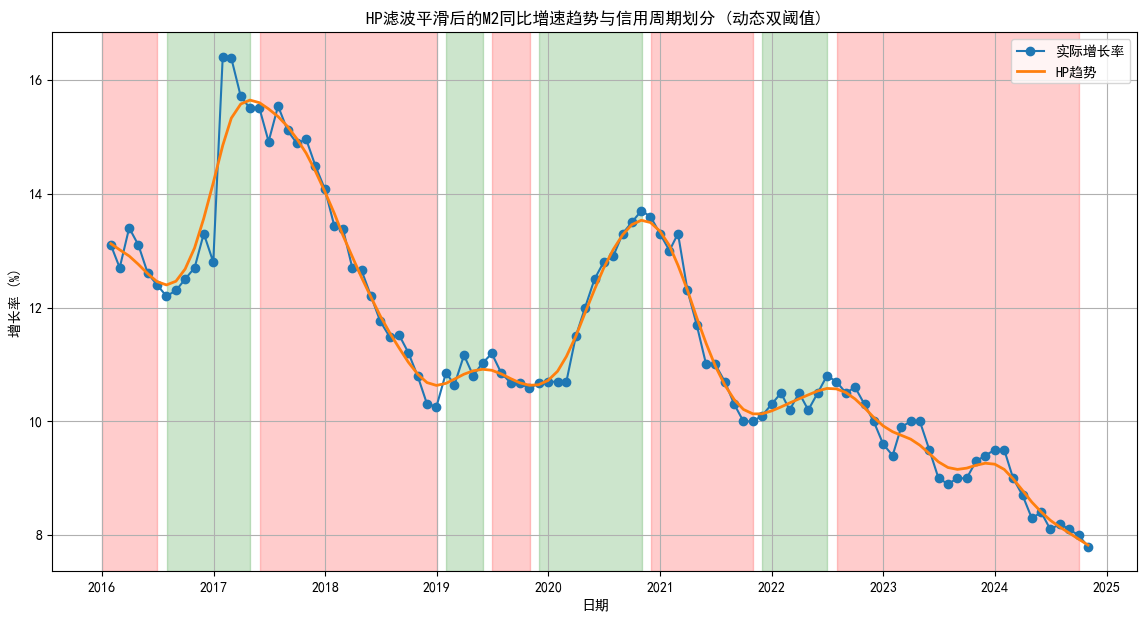

,信用周期,开始日期,结束日期,时长(月),指标
0,宽信用,2003-01,2003-09,9,M2同比增速
1,紧信用,2003-10,2004-12,15,M2同比增速
2,宽信用,2005-01,2006-04,16,M2同比增速
3,紧信用,2006-05,2007-01,9,M2同比增速
4,宽信用,2007-02,2007-10,9,M2同比增速
5,紧信用,2007-11,2008-09,11,M2同比增速
6,宽信用,2008-10,2009-11,14,M2同比增速
7,紧信用,2009-12,2012-02,27,M2同比增速
8,宽信用,2012-03,2013-04,14,M2同比增速
9,紧信用,2013-05,2014-03,11,M2同比增速


In [101]:
import pandas as pd

# 调用第一组数据
df1 = pd.DataFrame(m2_data_min_max)
summary_df1, trend1 = segment_credit_cycles_with_dynamic_threshold(df1, growth_col='中国:M2:同比', hp_lambda=10)
summary_df1['指标'] = 'M2同比增速'  # 添加一列标记数据来源

# 调用第二组数据
df2 = pd.DataFrame(social_financing_data_2)
summary_df2, trend2 = segment_credit_cycles_with_dynamic_threshold(df2, growth_col='中国:社会融资规模存量:同比', hp_lambda=10)
summary_df2['指标'] = '社会融资规模同比'  # 添加一列标记数据来源

# 合并两个结果
combined_summary_df = pd.concat([summary_df1, summary_df2], axis=0, ignore_index=True)

# 输出结果表格
combined_summary_df

In [63]:
periods_df.rename(columns={'start_date':'开始日期', 'end_date':'结束日期'}, inplace=True)

In [105]:
df2.dtypes

信用周期             object
开始日期             object
结束日期     datetime64[ns]
时长(月)             int64
指标               object
dtype: object

In [114]:
df1 = periods_df
df2 = combined_summary_df.copy()
df2['开始日期'] = pd.to_datetime(df2['开始日期']) 
df2['结束日期'] = pd.to_datetime(df2['结束日期'])  
df2['结束日期'] = df2['结束日期'] + pd.offsets.MonthEnd(0)

# 创建一个空的列表来存放合并后的数据
merged_data = []

# 遍历 df1 和 df2
for _, row1 in df1.iterrows():
    for _, row2 in df2.iterrows():
        # 检查是否有时间段重叠
        if (row1['开始日期'] <= row2['结束日期']) and (row1['结束日期'] >= row2['开始日期']):
            # 如果有重叠，则合并数据
            merged_data.append({
                '开始日期': max(row1['开始日期'], row2['开始日期']),
                '结束日期': min(row1['结束日期'], row2['结束日期']),
                '货币周期': row1['货币周期'],
                '信用周期': row2['信用周期'],
            })

# 创建新的 DataFrame
merged_df = pd.DataFrame(merged_data)

# 计算持续月份
merged_df['持续月份'] = ((merged_df['结束日期'].dt.year - merged_df['开始日期'].dt.year) * 12 + 
                     (merged_df['结束日期'].dt.month - merged_df['开始日期'].dt.month) + 1)

# 输出结果
merged_df

,开始日期,结束日期,货币周期,信用周期,持续月份
0,2003-01-01,2003-09-30,紧货币,宽信用,9
1,2003-10-01,2003-10-15,紧货币,紧信用,1
2,2003-10-15,2004-12-31,宽货币,紧信用,15
3,2005-01-01,2005-07-29,宽货币,宽信用,7
4,2005-07-29,2006-04-30,紧货币,宽信用,10
5,2006-05-01,2007-01-31,紧货币,紧信用,9
6,2007-02-01,2007-10-25,紧货币,宽信用,9
7,2007-10-25,2007-10-31,宽货币,宽信用,1
8,2007-11-01,2008-09-30,宽货币,紧信用,11
9,2008-10-01,2009-04-03,宽货币,宽信用,7
